In [6]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt;
import logging;
import os;
import time;
from datetime import date, datetime;
from flood_pred_data_processing_V1 import DataProcessor;
from flood_pred_models_V1 import FloodModel;
import seaborn as sns 


Processor = DataProcessor() 
surrey_df = Processor.process_surrey()
# print(surrey_df)
wu_df = Processor.concat_multiple_wu_stations()
# print (wu_df)

Model = FloodModel()  
model_df = Processor.build_model_matrix() 
# model_df.describe().transpose()[['mean', 'std']]

features_df = model_df.drop(columns=['water_level'])
# Normalize the data
normalizer = Model.model_data_normalizer(features_df)
normalized_features = normalizer(features_df.to_numpy())

# Reattach the target column
normalized_data = np.concatenate([normalized_features, model_df[['water_level']].to_numpy()], axis=1)
# Preparing train and test data for LSTM
n_past = 48  # e.g., use 12 hrs past time steps to predict
n_future = 16  # e.g., predict 4 hours ahead
# n_features = dynamic

X_train, y_train = Model.create_lstm_dataset(normalized_data, n_future, n_past)
X_test, y_test = Model.create_lstm_dataset(normalized_data, n_future, n_past)

n_features = normalized_data.shape[1]  # Assuming all columns except the target are features
input_shape = (n_past, n_features)

# Build the LSTM model
model = Model.build_lstm_model(input_shape)
history = Model.train_model(model, X_train, y_train, epochs=5, batch_size=n_past)
bi_direct_lstm_predictions = Model.predict_future(model, X_test)


# X_train, y_train = Model.create_lstm_dataset(normalized_data, n_future, n_past)
# X_test, y_test = Model.create_lstm_dataset(normalized_data, n_future, n_past)

# # Building and training the LSTM model
# lstm_model_wo_water = Model.build_lstm_model((X_train.shape[1], X_train.shape[2]))
# history = Model.train_model(lstm_model_wo_water, X_train, y_train, epochs=50)

# # Predicting future values
# predictions_wo_water = Model.predict_future(lstm_model_wo_water, X_test)





The dataframe is being concatenated
Epoch 1/5
126/126 [==============================] - 4s 23ms/step - loss: 1.0562 - val_loss: 0.1046
Epoch 2/5
126/126 [==============================] - 3s 22ms/step - loss: 0.0154 - val_loss: 0.1038
Epoch 3/5
126/126 [==============================] - 3s 22ms/step - loss: 0.0045 - val_loss: 0.0942
Epoch 4/5
126/126 [==============================] - 3s 22ms/step - loss: 0.0027 - val_loss: 0.0933
Epoch 5/5
209/209 [==============================] - 1s 4ms/step


In [7]:
# Evaluate the model
mae, mse, rmse, r2, bi_direct_lstm_predictions = Model.evaluate_model(model, X_test, y_test)
print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R²: {r2}')


209/209 [==============================] - 1s 5ms/step
Mean Absolute Error: 0.04437557858184188
Mean Squared Error: 0.010821346953268187
Root Mean Squared Error: 0.10402570332984146
R² Score: 0.9704956654957119
MAE: 0.04437557858184188, MSE: 0.010821346953268187, RMSE: 0.10402570332984146, R²: 0.9704956654957119


In [8]:

# Create dataset for Scikit-learn model
X_train_lr, y_train_lr = Model.create_sklearn_dataset(normalized_data, n_future, n_past)
X_test_lr, y_test_lr = Model.create_sklearn_dataset(normalized_data, n_future, n_past)

# Build, train, and evaluate the linear regression model
lr_model, lr_mae, lr_mse, lr_rmse, lr_r2, lr_predictions = Model.sklearn_autoregressive_linear_model(X_train_lr, y_train_lr, X_test_lr, y_test_lr)



Scikit-learn Autoregressive Linear Model - MAE: 0.08693700827466988, MSE: 0.012468414743916767, RMSE: 0.11166205597210167, R²: 0.9660049455089676


(6671,)


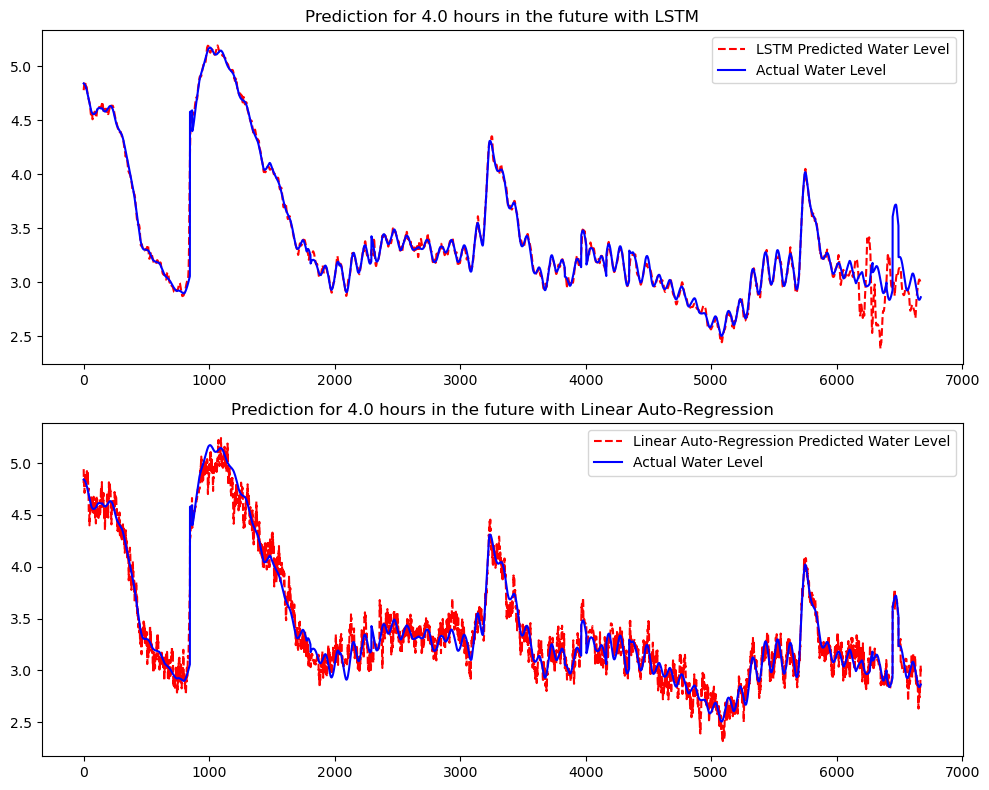

In [9]:
print(lr_predictions.shape)

Model.plot_model_predictions(y_test_lr, [bi_direct_lstm_predictions, lr_predictions],['LSTM', 'Linear Auto-Regression'], 16)



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import os
import time
from datetime import date, datetime
from flood_pred_data_processing_V1 import DataProcessor
from flood_pred_models_V1 import FloodModel
import seaborn as sns 

Processor = DataProcessor() 
Model = FloodModel()  
# Preparing train and test data for LSTM
n_past = 48  # e.g., use 48 past time steps to predict
n_future = 16  # e.g., predict 16 future time steps

Processor.process_surrey_water_level()
Processor.process_surrey_flow_rate()
Processor.concat_multiple_wu_stations()

model_df_wo_surrey = Processor.build_model_matrix_wo_predictions_as_parameters() 
model_df_with_surrey = Processor.build_model_matrix_w_predictions_as_parameters() 

# Splitting the data into training and testing sets
train_df_wo_surrey, test_df_wo_surrey = Model.split_df(model_df_wo_surrey, n_future)
train_df_with_surrey, test_df_with_surrey = Model.split_df(model_df_with_surrey, n_future)

# print(train_df_wo_surrey)
# Separate the features and targets in the split data
train_features_wo_surrey = train_df_wo_surrey.drop(columns=['water_level', 'flow_rate'])
test_features_wo_surrey = test_df_wo_surrey.drop(columns=['water_level', 'flow_rate'])

train_features_with_surrey = train_df_with_surrey.drop(columns=['water_level', 'flow_rate'])
test_features_with_surrey = test_df_with_surrey.drop(columns=['water_level', 'flow_rate'])

# Normalize the features
normalizer_wo_surrey = Model.model_data_normalizer(train_features_wo_surrey)
train_normalized_features_wo_surrey = normalizer_wo_surrey(train_features_wo_surrey.to_numpy())
test_normalized_features_wo_surrey = normalizer_wo_surrey(test_features_wo_surrey.to_numpy())
# print(test_normalized_features_wo_surrey)
normalizer_with_surrey = Model.model_data_normalizer(train_features_with_surrey)
train_normalized_features_with_surrey = normalizer_with_surrey(train_features_with_surrey.to_numpy())
test_normalized_features_with_surrey = normalizer_with_surrey(test_features_with_surrey.to_numpy())

# Concatenate normalized features with the target columns
train_normalized_data_wo_surrey = np.concatenate(
    [train_normalized_features_wo_surrey, train_df_wo_surrey[['water_level', 'flow_rate']].to_numpy()], axis=1)
# print(train_normalized_data_wo_surrey)
test_normalized_data_wo_surrey = np.concatenate(
    [test_normalized_features_wo_surrey, test_df_wo_surrey[['water_level', 'flow_rate']].to_numpy()], axis=1)
# print(test_normalized_data_wo_surrey)
train_normalized_data_with_surrey = np.concatenate(
    [train_normalized_features_with_surrey, train_df_with_surrey[['water_level', 'flow_rate']].to_numpy()], axis=1)

test_normalized_data_with_surrey = np.concatenate(
    [test_normalized_features_with_surrey, test_df_with_surrey[['water_level', 'flow_rate']].to_numpy()], axis=1)

X_train_wo, y_train_wo = Model.create_lstm_dataset(train_normalized_data_wo_surrey, n_future, n_past)

X_test_wo, y_test_wo = Model.create_lstm_dataset(test_normalized_data_wo_surrey, n_future, n_past)

X_train_with, y_train_with = Model.create_lstm_dataset(train_normalized_data_with_surrey, n_future, n_past)
X_test_with, y_test_with = Model.create_lstm_dataset(test_normalized_data_with_surrey, n_future, n_past)
# print(X_train_with.shape)
n_features_wo = train_normalized_data_wo_surrey.shape[1] -2 
input_shape_wo = (n_past, n_features_wo)

model_wo = Model.build_lstm_model_w_attention(input_shape_wo)

n_features_with = train_normalized_data_with_surrey.shape[1] - 2
input_shape_with = (n_past, n_features_with)
model_with = Model.build_lstm_model_w_attention(input_shape_with)

# Training the models
history_wo = Model.train_model(model_wo, X_train_wo, y_train_wo, epochs=2, batch_size=n_past)
history_with = Model.train_model(model_with, X_train_with, y_train_with, epochs=2, batch_size=n_past)
# print(history_wo.history)
# Predictions

bi_direct_lstm_predictions_wo = Model.predict_future(model_wo, X_test_wo)
bi_direct_lstm_predictions_with = Model.predict_future(model_with, X_test_with)

# Model evaluation
Model.evaluate_model(model_wo, X_test_wo, y_test_wo)
Model.evaluate_model(model_with, X_test_with, y_test_with)

The dataframe is being concatenated


2024-01-28 13:59:35.477392: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/2
108/108 [==============================] - 11s 99ms/step - loss: 0.8651 - val_loss: 0.5976
Epoch 2/2
108/108 [==============================] - 11s 98ms/step - loss: 0.0107 - val_loss: 0.5312
Epoch 1/2
108/108 [==============================] - 11s 97ms/step - loss: 1.1199 - val_loss: 0.5140
Epoch 2/2
2/2 [==============================] - 0s 32ms/step
Target: Water Level - MAE: 0.11100026429104974, MSE: 0.01683238304066819, RMSE: 0.12973967411963155, R²: -3.4354323714548842
Target: Flow Rate - MAE: 0.14427662190936857, MSE: 0.023381191327029024, RMSE: 0.15290909497812424, R²: -19.21504518910582
2/2 [==============================] - 0s 33ms/step
Target: Water Level - MAE: 0.09127761704581118, MSE: 0.010807558191887515, RMSE: 0.10395940646178928, R²: -1.847855431097496
Target: Flow Rate - MAE: 0.16175920841645222, MSE: 0.03293010146635311, RMSE: 0.18146652987907472, R²: -27.47089696642734


array([[2.8563402 , 0.706717  ],
       [2.851397  , 0.70725423],
       [2.8477502 , 0.7089712 ],
       [2.845404  , 0.71156865],
       [2.8443854 , 0.71451694],
       [2.8443048 , 0.7176665 ],
       [2.845144  , 0.7209722 ],
       [2.8466005 , 0.7243976 ],
       [2.8486397 , 0.727794  ],
       [2.8514197 , 0.7309581 ],
       [2.8547192 , 0.73390245],
       [2.8580577 , 0.73665994],
       [2.8613977 , 0.73925877],
       [2.8646693 , 0.74161917],
       [2.8676465 , 0.74383456],
       [2.8704686 , 0.74596095],
       [2.8729942 , 0.74796516],
       [2.8751779 , 0.74978197],
       [2.877037  , 0.75147927],
       [2.8793242 , 0.7534292 ],
       [2.8812072 , 0.7552274 ],
       [2.8828876 , 0.7570877 ],
       [2.884817  , 0.75940096],
       [2.886494  , 0.76203233],
       [2.8879392 , 0.7647723 ],
       [2.8897097 , 0.76794493],
       [2.8917625 , 0.7714584 ],
       [2.8942266 , 0.77557296],
       [2.8973126 , 0.7803369 ],
       [2.9008615 , 0.78543717],
       [2.

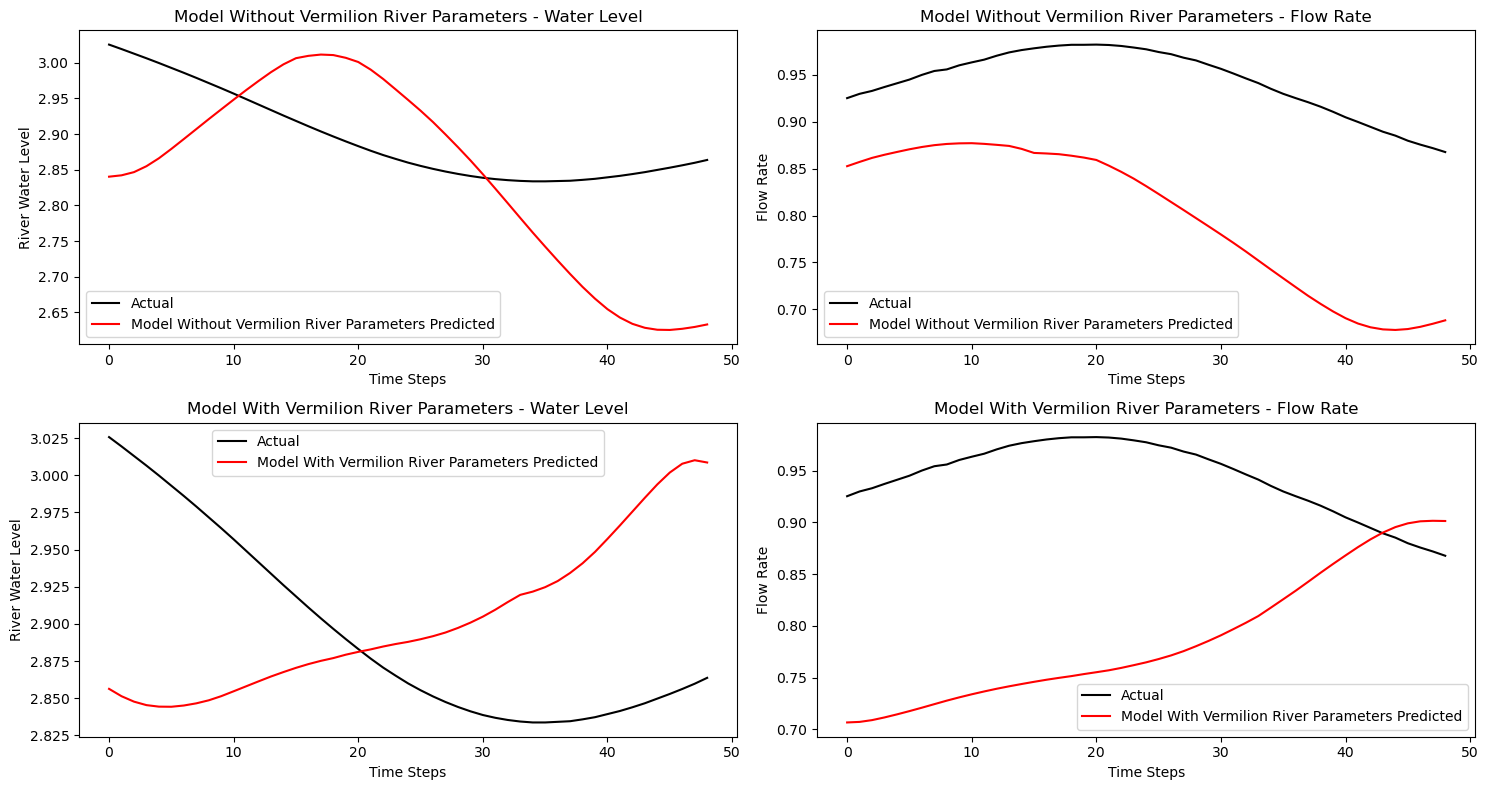

In [2]:
Model.plot_model_predictions(y_test_wo, [bi_direct_lstm_predictions_wo, bi_direct_lstm_predictions_with], ['Model Without Vermilion River Parameters', 'Model With Vermilion River Parameters'])

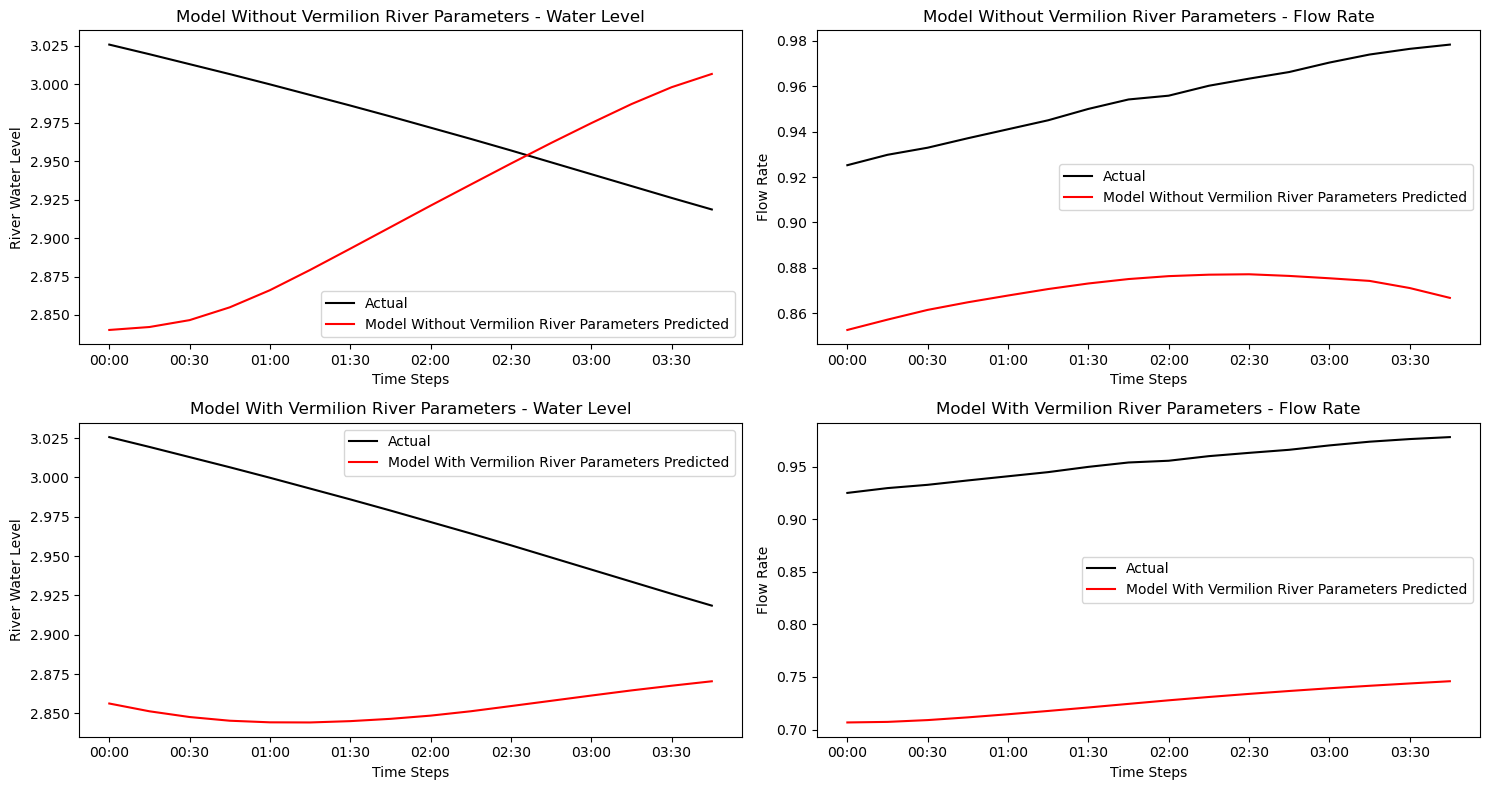

In [3]:
Model.plot_4_hour_prediction(y_test_wo, [bi_direct_lstm_predictions_wo, bi_direct_lstm_predictions_with], ['Model Without Vermilion River Parameters', 'Model With Vermilion River Parameters'])